Kemal Demirel

191104091

HW2- SORU2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1-Load a gray scale image and a template

Load a gray scale image

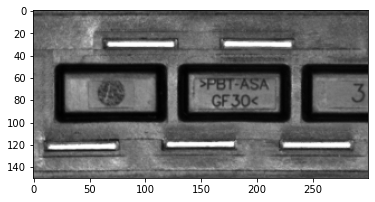

In [3]:
gray_scale_image = cv2.imread('connectors.png', 0)
plt.imshow(gray_scale_image, cmap='gray')
plt.show()

Load a template

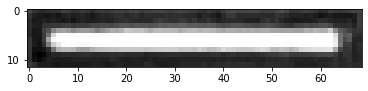

In [4]:
template = cv2.imread('connector_pattern.png', 0)
plt.imshow(template, cmap='gray')
plt.show()

## 2- Implement a correlation

In [48]:

def correlation(image, template):
    img_h, img_w = image.shape
    tpl_h, tpl_w = template.shape
    corr = np.zeros((img_h - tpl_h + 1, img_w - tpl_w + 1))
    for y in range(corr.shape[0]):
        for x in range(corr.shape[1]):
            img_patch = image[y:y+tpl_h, x:x+tpl_w]
            corr[y, x] = np.sum(template * img_patch)
    return corr


Correlation is computed

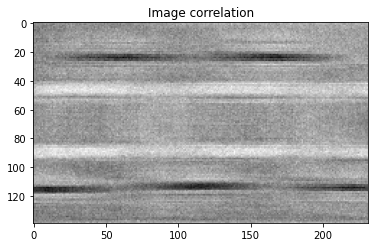

In [49]:
result_correlation = correlation(gray_scale_image, template)
plt.imshow(result_correlation, cmap='gray')
plt.title("Image correlation")
plt.show()

## 3- Implement Zero-mean correlation

In [7]:
def zero_mean_correlation(image, template):
    # Compute mean of template
    tpl_mean = np.mean(template)

    # Subtract mean from template and image patch
    template = template - tpl_mean
    image = image - np.mean(image)

    # Compute correlation using the correlation function
    corr = correlation(image, template)

    return corr


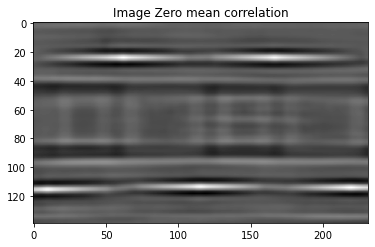

In [8]:
result_zero_mean_correlation = zero_mean_correlation(gray_scale_image, template)
plt.imshow(result_zero_mean_correlation, cmap='gray')
plt.title("Image Zero mean correlation")
plt.show()

## 4- Implement Sum Square Difference:

In [38]:
def sum_square_difference(img, template):
    img = img.astype(np.int64)
    template = template.astype(np.int64)
    res = np.zeros((img.shape[0]- template.shape[0], img.shape[1]- template.shape[1] ))
    for i in range(img.shape[0] - template.shape[0]):
        for j in range(img.shape[1]- template.shape[1]):
            sum = 0
            for ti in range(template.shape[0]):
                for tj in range(template.shape[1]):
                    sum += ( template[ti][tj] - img[i+ti][j+tj] ) ** 2 
            res[i][j] = sum
    return res

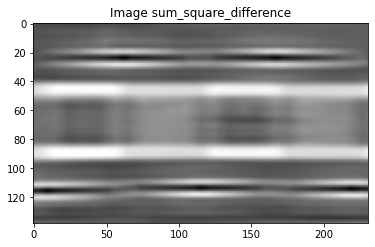

In [39]:
result_sum_square_difference = sum_square_difference(gray_scale_image, template)
plt.imshow(result_sum_square_difference, cmap='gray')
plt.title("Image sum_square_difference")
plt.show()

## 5- Implement Normalized Cross Correlation:

In [11]:
def normalized_cross_correlation(image, template):
    img_h, img_w = image.shape
    tpl_h, tpl_w = template.shape
    tpl_mean = np.mean(template)
    img_mean = np.mean(image)
    tpl_std = np.std(template)
    img_std = np.std(image)
    ncc = np.zeros((img_h - tpl_h + 1, img_w - tpl_w + 1))
    for y in range(ncc.shape[0]):
        for x in range(ncc.shape[1]):
            img_patch = image[y:y+tpl_h, x:x+tpl_w]
            numerator = np.sum((template - tpl_mean) * (img_patch - img_mean))
            denominator = tpl_std * img_std * tpl_w * tpl_h
            ncc[y, x] = numerator / denominator
    return ncc


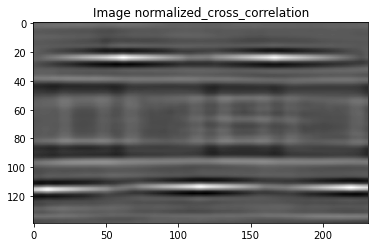

In [12]:
result_normalized_cross_correlation = normalized_cross_correlation(gray_scale_image, template)
plt.imshow(result_normalized_cross_correlation, cmap='gray')
plt.title("Image normalized_cross_correlation")
plt.show()

## 6- Apply your template matching functions to the following images and templates: 

### A grayscale image with a rectangular template

In [27]:
rect_tpl = template

In [40]:
corr_rect = cv2.matchTemplate(gray_scale_image, rect_tpl, cv2.TM_CCORR_NORMED)
zmcorr_rect = zero_mean_correlation(gray_scale_image, rect_tpl)
ssd_rect = sum_square_difference(gray_scale_image, rect_tpl)
ncc_rect = normalized_cross_correlation(gray_scale_image, rect_tpl)

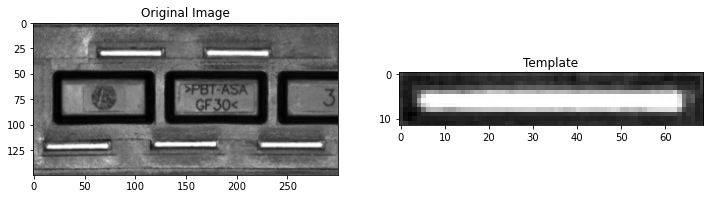

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(gray_scale_image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(rect_tpl, cmap='gray')
axs[1].set_title('Template')

plt.show()

Text(0.5, 1.0, 'Normalized Cross Correlation')

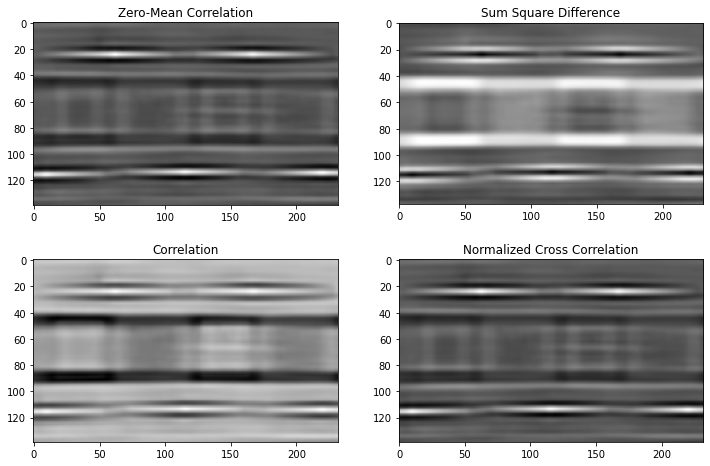

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].imshow(zmcorr_rect, cmap='gray')
axs[0,0].set_title('Zero-Mean Correlation')

axs[0,1].imshow(ssd_rect, cmap='gray')
axs[0,1].set_title('Sum Square Difference')

axs[1,0].imshow(corr_rect, cmap='gray')
axs[1,0].set_title('Correlation')

axs[1,1].imshow(ncc_rect, cmap='gray')
axs[1,1].set_title('Normalized Cross Correlation')


### A grayscale image with a circular template

In [44]:
circ_tpl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))

In [45]:
ncc_circ = normalized_cross_correlation(gray_scale_image, circ_tpl)
corr_circ = cv2.matchTemplate(gray_scale_image, circ_tpl, cv2.TM_CCORR_NORMED)
ssd_circ = sum_square_difference(gray_scale_image, circ_tpl)
zmcorr_circ = zero_mean_correlation(gray_scale_image, circ_tpl)

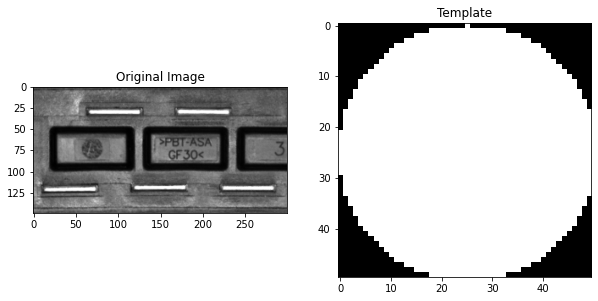

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(gray_scale_image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(circ_tpl, cmap='gray')
axs[1].set_title('Template')
plt.show()

Text(0.5, 1.0, 'Sum Square Difference')

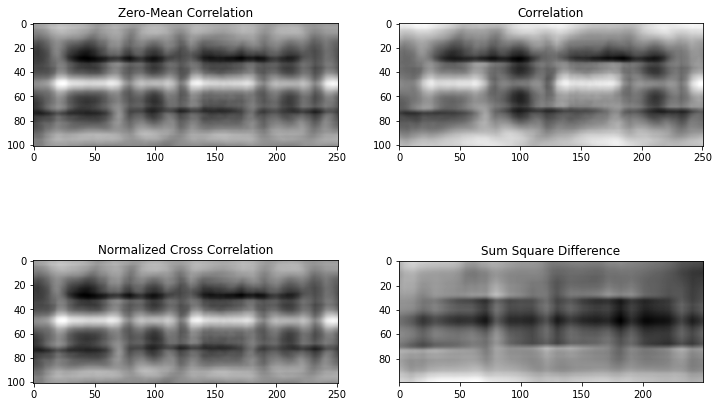

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(zmcorr_circ, cmap='gray')
axs[0, 0].set_title('Zero-Mean Correlation')
axs[0, 1].imshow(corr_circ, cmap='gray')
axs[0, 1].set_title('Correlation')

axs[1, 0].imshow(ncc_circ, cmap='gray')
axs[1, 0].set_title('Normalized Cross Correlation')
axs[1, 1].imshow(ssd_circ, cmap='gray')
axs[1, 1].set_title('Sum Square Difference')

## 7- After applying the template matching function, you will have an output image where each pixel represents the similarity measure between the template and the image at that location. To identify the matches, you can apply a threshold to the output image and then find the local maxima.

In [65]:
def find_matches(image, template, threshold, method):
    # Apply template matching function
    if method == 'corr':
        output = zero_mean_correlation(image, template)
    elif method == 'ssd':
        output = sum_square_difference(image, template)
    elif method == 'ncc':
        output = normalized_cross_correlation(image, template)
    else:
        output = zero_mean_correlation(image, template)
        

    # Threshold the output image to identify potential matches
    thresholded_output = np.zeros_like(output)
    thresholded_output[output > threshold] = 255

    # Find local maxima in the thresholded image
    local_maxima = np.zeros_like(thresholded_output)
    h, w = thresholded_output.shape[:2]
    for i in range(1, h-1):
        for j in range(1, w-1):
            if thresholded_output[i, j] > 0:
                patch = thresholded_output[i-1:i+2, j-1:j+2]
                if np.max(patch) == thresholded_output[i, j]:
                    local_maxima[i, j] = 255

    # Find the positions of the local maxima and record them as matches
    matches = []
    contours, _ = cv2.findContours(local_maxima.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            matches.append((cx, cy))
    
    '''        
    # Find the positions of the local maxima and record them as matches
    matches = []
    for y in range(1, local_maxima.shape[0]-1):
        for x in range(1, local_maxima.shape[1]-1):
            if local_maxima[y, x] > threshold:
                if local_maxima[y, x] > local_maxima[y-1, x] and \
                local_maxima[y, x] > local_maxima[y+1, x] and \
                local_maxima[y, x] > local_maxima[y, x-1] and \
                local_maxima[y, x] > local_maxima[y, x+1] and \
                local_maxima[y, x] > local_maxima[y-1, x-1] and \
                local_maxima[y, x] > local_maxima[y+1, x+1] and \
                local_maxima[y, x] > local_maxima[y-1, x+1] and \
                local_maxima[y, x] > local_maxima[y+1, x-1]:
                    matches.append((x, y))
    '''
    # Overlay rectangles or circles on the original image at the positions of the matches
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if template.shape[0] > 1 and template.shape[1] > 1:
        for match in matches:
            if method == 'corr':
                cv2.rectangle(output_image, (match[0], match[1]), (match[0]+template.shape[1], match[1]+template.shape[0]), (0, 255, 0), 2)
            else:
                cv2.circle(output_image, (match[0], match[1]), int(template.shape[1]/2), (0, 255, 0), 2)
    else:
        for match in matches:
            cv2.drawMarker(output_image, (match[0], match[1]), (0, 255, 0), cv2.MARKER_CROSS, 10, 2)

    return output, thresholded_output, local_maxima, output_image, matches

In [66]:
output, thresholded_output, local_maxima, output_image, matches = find_matches(gray_scale_image, template, 0.8, 'ssd')

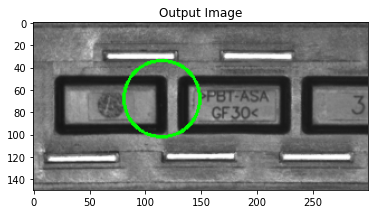

In [67]:
plt.imshow(output_image, cmap='gray')
plt.title("Output Image")
plt.show()

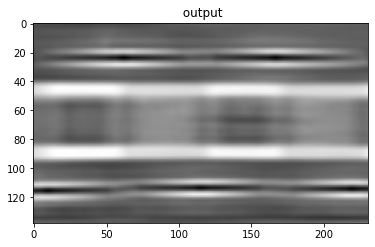

In [68]:
plt.imshow(output, cmap='gray')
plt.title(" output")
plt.show()